In [1]:
from bleak import BleakScanner
from bleak.backends.device import BLEDevice
from bleak.backends.scanner import AdvertisementData
import asyncio
import jsonpickle
import time
from datetime import datetime

In [2]:
%matplotlib inline
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from IPython.display import display,clear_output
from ipywidgets import Output

In [4]:
GOVEE_OUI = "a4:c1:38"
def c_to_f(c: float) -> float:
    return (c * 9 / 5) + 32

In [5]:
class GoveeDevice:
    def __init__(self, device: BLEDevice):
        self._device = device
        self._battery = None
        self.history_length = 30
        self._temperatures = {}
        self.allowedSlots=[1,2,3,8,16,32]
        self.avgs={}
        
    def parseAdvert(self, advertisement: AdvertisementData):
        data = advertisement.manufacturer_data.get(12999)
        self.process_data = []
        if data is not None:
            """with hexOut:
                for i in range(0,len(data)):
                    print(str(data[i]).ljust(3, ),end=' ')
                    self.process_data.append(str(data[i]))
                print()
            """
            self._battery = int(data[2])
            _slot = int(data[3])     
            if _slot in self.allowedSlots:   
                if _slot not in self._temperatures:
                    self._temperatures[_slot] = {'value':None,'last_update':0,'history':[]}
                if self._temperatures[_slot]['value'] != c_to_f(int(data[5])):
                    if self._temperatures[_slot]['value'] is not None:
                        self._temperatures[_slot]['history'].append({'value':self._temperatures[_slot]['value'],'date':self._temperatures[_slot]['last_update']})
                        if len(self._temperatures[_slot]['history']) > self.history_length:
                            self._temperatures[_slot]['history'].pop(0)
                        
                        history_values = [i['value']  for i in self._temperatures[_slot]['history']]
                        self.avgs[_slot] = sum(history_values)/len(history_values)
                    self._temperatures[_slot]['value'] = c_to_f(int(data[5]))
                self._temperatures[_slot]['last_update']=datetime.now()
        return self
    def dict(self):
        return {
            'name': self._device.name,
            'address': self._device.address,
            'battery': self._battery,
            'temperatures': self._temperatures
        }

    def __repr__(self):
        return str(self.dict())
    
    def summarize(self):
        for sensor in self._temperatures:
            s = self._temperatures[sensor]
            print(f"Sensor {sensor}")
            print(f"current temp: {s['value']}")
            if len(s['history'])>0:
                history_values = [f"{i['value']}"  for i in s['history']]
                print("History:",'(Avg: ',self.avgs[sensor],")")
                for item in s['history']:
                    print(f"\t{item['date']} = {item['value']}")

In [6]:
devices = {}
def process_advertisement(device: BLEDevice, advertisement: AdvertisementData):
    global devices
    if not str(device.address).lower().startswith(GOVEE_OUI):
        return
    if device.address not in devices:
        devices[device.address] = GoveeDevice(device)
        
    device = devices[device.address].parseAdvert(advertisement)
    return device

In [7]:
class GoveeScanner:
    def __init__(self, addresses=[]):
        self._callbacks = []
        self.addresses = addresses
        self.scanner = None

    def register(self, callback):
        self._callbacks.append(callback)

    def unregister(self, callback):
        self._callbacks.remove(callback)
        
    async def discoverDevices(self):
        print('discovery mode')
        await scanner.start()
        await asyncio.sleep(5.0)
        await scanner.stop()
        
    async def start(self):
        def _callback(device: BLEDevice, adv: AdvertisementData):
            if device.address in self.addresses or len(self.addresses) ==0:
                adv = process_advertisement(device, adv)
                if adv:    
                    with dictOut:
                        clear_output()
                        adv.summarize()
                    for callback in self._callbacks:
                        callback(adv)
        self.scanner = BleakScanner(adapter="hci1")
        self.scanner.register_detection_callback(_callback)
        print('starting')
        await self.scanner.start()

    async def stop(self):
        print('stopping')
        await self.scanner.stop()

In [8]:
scanner = GoveeScanner(addresses=['A4:C1:38:C7:32:4B'])

In [9]:
import requests


last_alert = time.time()-30
def temp_monitor(device):
    global last_alert
    if 1 in device._temperatures.keys():
        if device._temperatures[1]['value'] > 164:
            print("ALERTING")
            if (time.time()-last_alert)>30:
                last_alert = time.time()
                message=f"temp is: {device._temperatures[1]['value']}"
                print(message)scanner.register(temp_monitor)


scanner.unregister(temp_monitor)

In [10]:
alertOut = Output()
display(alertOut)

Output()

In [11]:
hexOut = Output()
display(hexOut)

Output()

In [12]:
dictOut = Output()
display(dictOut)

Output()

In [13]:
await scanner.discoverDevices()

discovery mode
starting
stopping


In [14]:
devices.keys()

dict_keys(['A4:C1:38:C7:32:4B'])

In [15]:
try:
    await scanner.start()

    while True:
        await asyncio.sleep(10.0)
except asyncio.CancelledError:
    await scanner.stop()

starting
stopping


In [16]:
devices['A4:C1:38:C7:32:4B']._temperatures[1]

{'value': 80.6,
 'last_update': datetime.datetime(2022, 8, 11, 12, 11, 42, 907866),
 'history': [{'value': 82.4,
   'date': datetime.datetime(2022, 8, 11, 12, 4, 23, 495541)},
  {'value': 84.2, 'date': datetime.datetime(2022, 8, 11, 12, 5, 43, 858079)},
  {'value': 86.0, 'date': datetime.datetime(2022, 8, 11, 12, 5, 55, 632356)},
  {'value': 84.2, 'date': datetime.datetime(2022, 8, 11, 12, 6, 2, 284770)},
  {'value': 82.4, 'date': datetime.datetime(2022, 8, 11, 12, 6, 14, 62748)},
  {'value': 80.6, 'date': datetime.datetime(2022, 8, 11, 12, 6, 44, 781269)},
  {'value': 82.4, 'date': datetime.datetime(2022, 8, 11, 12, 6, 57, 601448)},
  {'value': 80.6, 'date': datetime.datetime(2022, 8, 11, 12, 7, 9, 892332)},
  {'value': 78.8, 'date': datetime.datetime(2022, 8, 11, 12, 7, 27, 829667)},
  {'value': 80.6, 'date': datetime.datetime(2022, 8, 11, 12, 7, 59, 103538)},
  {'value': 82.4, 'date': datetime.datetime(2022, 8, 11, 12, 8, 17, 472958)},
  {'value': 84.2, 'date': datetime.datetime(202

/tmp/ipykernel_200071/1164004365.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(cdu, "r*-", markersize=6, linewidth=1, color='black', label="CDU")
/tmp/ipykernel_200071/1164004365.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(gruene, "r*-", markersize=6, linewidth=1, color='g', label="Gruene")


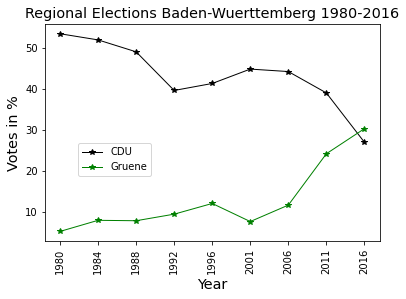

In [17]:
import numpy as np

# results for the greens and the cdu
gruene = np.array([5.3, 8.0, 7.9, 9.5, 12.1, 7.7, 11.7, 24.2, 30.3])
cdu = np.array([53.4, 51.9, 49.0, 39.6, 41.3, 44.8, 44.2, 39.0, 27.0])

fig, ax = plt.subplots()
xlabels = [1980, 1984, 1988, 1992, 1996, 2001, 2006, 2011, 2016]

plt.title("Regional Elections Baden-Wuerttemberg 1980-2016", size="x-large")
plt.ylabel("Votes in %", size="x-large")
plt.xlabel("Year", size="x-large")

# plot the data
plt.plot(cdu, "r*-", markersize=6, linewidth=1, color='black', label="CDU")
plt.plot(gruene, "r*-", markersize=6, linewidth=1, color='g', label="Gruene")

# add legend
plt.legend(loc=(0.1, 0.3))

# add x-labels
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation='vertical')

plt.show()

In [18]:
devices

{'A4:C1:38:C7:32:4B': {'name': 'Govee_H5055_324B', 'address': 'A4:C1:38:C7:32:4B', 'battery': 100, 'temperatures': {1: {'value': 80.6, 'last_update': datetime.datetime(2022, 8, 11, 12, 11, 42, 907866), 'history': [{'value': 82.4, 'date': datetime.datetime(2022, 8, 11, 12, 4, 23, 495541)}, {'value': 84.2, 'date': datetime.datetime(2022, 8, 11, 12, 5, 43, 858079)}, {'value': 86.0, 'date': datetime.datetime(2022, 8, 11, 12, 5, 55, 632356)}, {'value': 84.2, 'date': datetime.datetime(2022, 8, 11, 12, 6, 2, 284770)}, {'value': 82.4, 'date': datetime.datetime(2022, 8, 11, 12, 6, 14, 62748)}, {'value': 80.6, 'date': datetime.datetime(2022, 8, 11, 12, 6, 44, 781269)}, {'value': 82.4, 'date': datetime.datetime(2022, 8, 11, 12, 6, 57, 601448)}, {'value': 80.6, 'date': datetime.datetime(2022, 8, 11, 12, 7, 9, 892332)}, {'value': 78.8, 'date': datetime.datetime(2022, 8, 11, 12, 7, 27, 829667)}, {'value': 80.6, 'date': datetime.datetime(2022, 8, 11, 12, 7, 59, 103538)}, {'value': 82.4, 'date': datet

In [ ]:
for advert in scanner.adverts:
    for i in range(0,len(advert.process_data)):
        print(str(advert.process_data[i]).ljust(3, ),end=' ')
    print()

In [ ]:
dir(scanner.adverts[0])

In [ ]:
while True:
    time.sleep(1)